# 使用OSMnx绘制等时线图

15分钟步行距离圈

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11dev'

In [2]:
# 设置地点，网络类型，旅行时间和移动速度
place = 'Nankai District, TianJin, CN'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25,30,35,40,45,50,55,60] #in minutes
travel_speed = 4.5 #walking speed in km/hour

## 下载并准备街道网络

In [3]:
# 下载路网
G = ox.graph_from_place(place, network_type=network_type)

In [4]:
# 找到最中心的节点，然后将图形投影到UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [5]:
# 添加边缘属性，以分钟为单位来遍历每个边缘所需的时间
meters_per_minute = travel_speed * 1000 / 60   #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## 绘制每次可以步行到达的节点

您可以在距起点5、10、15、20和25分钟的路程中走多远？可以使用NetworkX根据行程时间和行驶速度在每个距离内得出G的子图。

In [6]:
# 每个等时线获得一种颜色
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

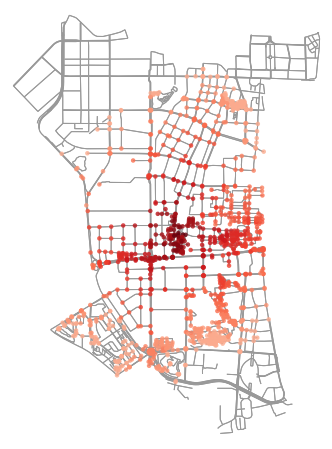

In [7]:
# 根据等时线对节点着色，然后绘制街道网络
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

## 将时间距离绘制为等时线

您可以在距起点5、10、15、20和25分钟的路程中走多远？我们将使用不完全准确的凸包，而凹壳会更好，但形状不能提供这种功能。

In [8]:
# 制作等时线多边形
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

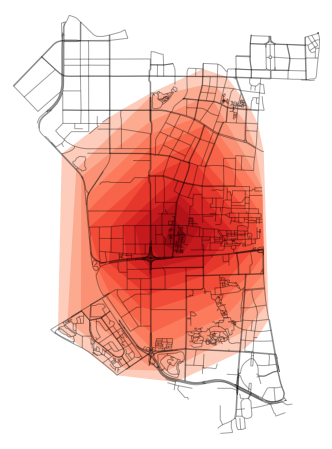

In [9]:
# 绘制网络，然后将等时线添加为彩色笛卡尔多边形面片
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## 或者，绘制等时线作为缓冲区，以获得比凸包所能提供的更准确的等时线

 http://kuanbutts.com/2017/12/16/osmnx-isochrones/

In [15]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys



In [16]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

AttributeError: 'Point' object has no attribute 'geometry'